In [1]:
### Based on bank users accounts data, the goal is to predict when a customer leaves the bank

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
data = pd.read_csv("train.csv")
inference = pd.read_csv("inference.csv")

In [3]:
### Verify missing values and types

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148531 entries, 0 to 148530
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               148531 non-null  int64  
 1   CustomerId       148531 non-null  int64  
 2   Surname          148531 non-null  object 
 3   CreditScore      148531 non-null  int64  
 4   Geography        148531 non-null  object 
 5   Gender           148531 non-null  object 
 6   Age              148531 non-null  float64
 7   Tenure           148531 non-null  int64  
 8   Balance          148531 non-null  float64
 9   NumOfProducts    148531 non-null  int64  
 10  HasCrCard        148531 non-null  float64
 11  IsActiveMember   148531 non-null  float64
 12  EstimatedSalary  148531 non-null  float64
 13  Churn            148531 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 15.9+ MB


In [4]:
### Check imbalance

data["Churn"].value_counts()

Churn
0    117102
1     31429
Name: count, dtype: int64

In [5]:
# Then, the evaluation metric shouldn't be "accuracy"

# Since in this case we wanted to avoid customer churn, one good metric could be "recall", because the focus
# is indentify customers with a high probability of leaving to take actions

<Axes: xlabel='Geography', ylabel='percent'>

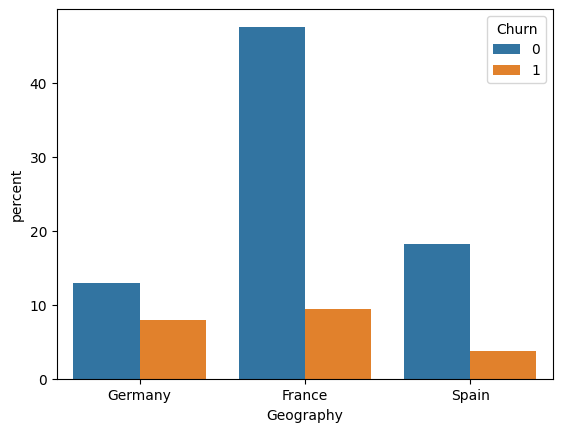

In [6]:
### Check if Gender and Geography should be considered prediction variables and look at their categories 

sb.countplot(data, x="Geography", hue="Churn", stat="percent")

<Axes: xlabel='Gender', ylabel='percent'>

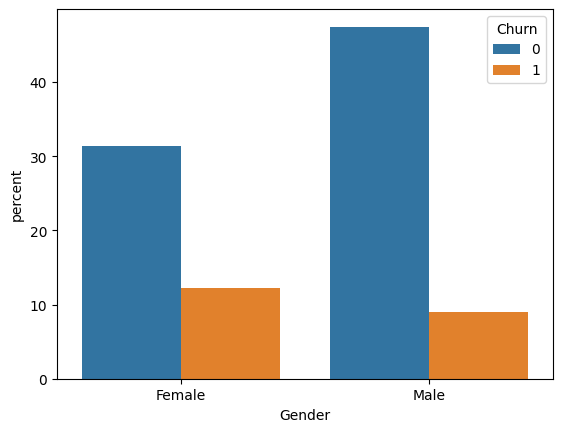

In [7]:
# The german proportion that "churn" in regards to total germans is high in comparison with the other countries,
# hence, this variable should be included

sb.countplot(data, x="Gender", hue="Churn", stat="percent")

# Something similar happens with females

In [8]:
### Categorical variables non binary
cat_vars_nb = ["Geography", "Gender"]

### Categorical variables binary
cat_vars = [ "HasCrCard", "IsActiveMember" ]

### Continuous variables
con_vars = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary"]

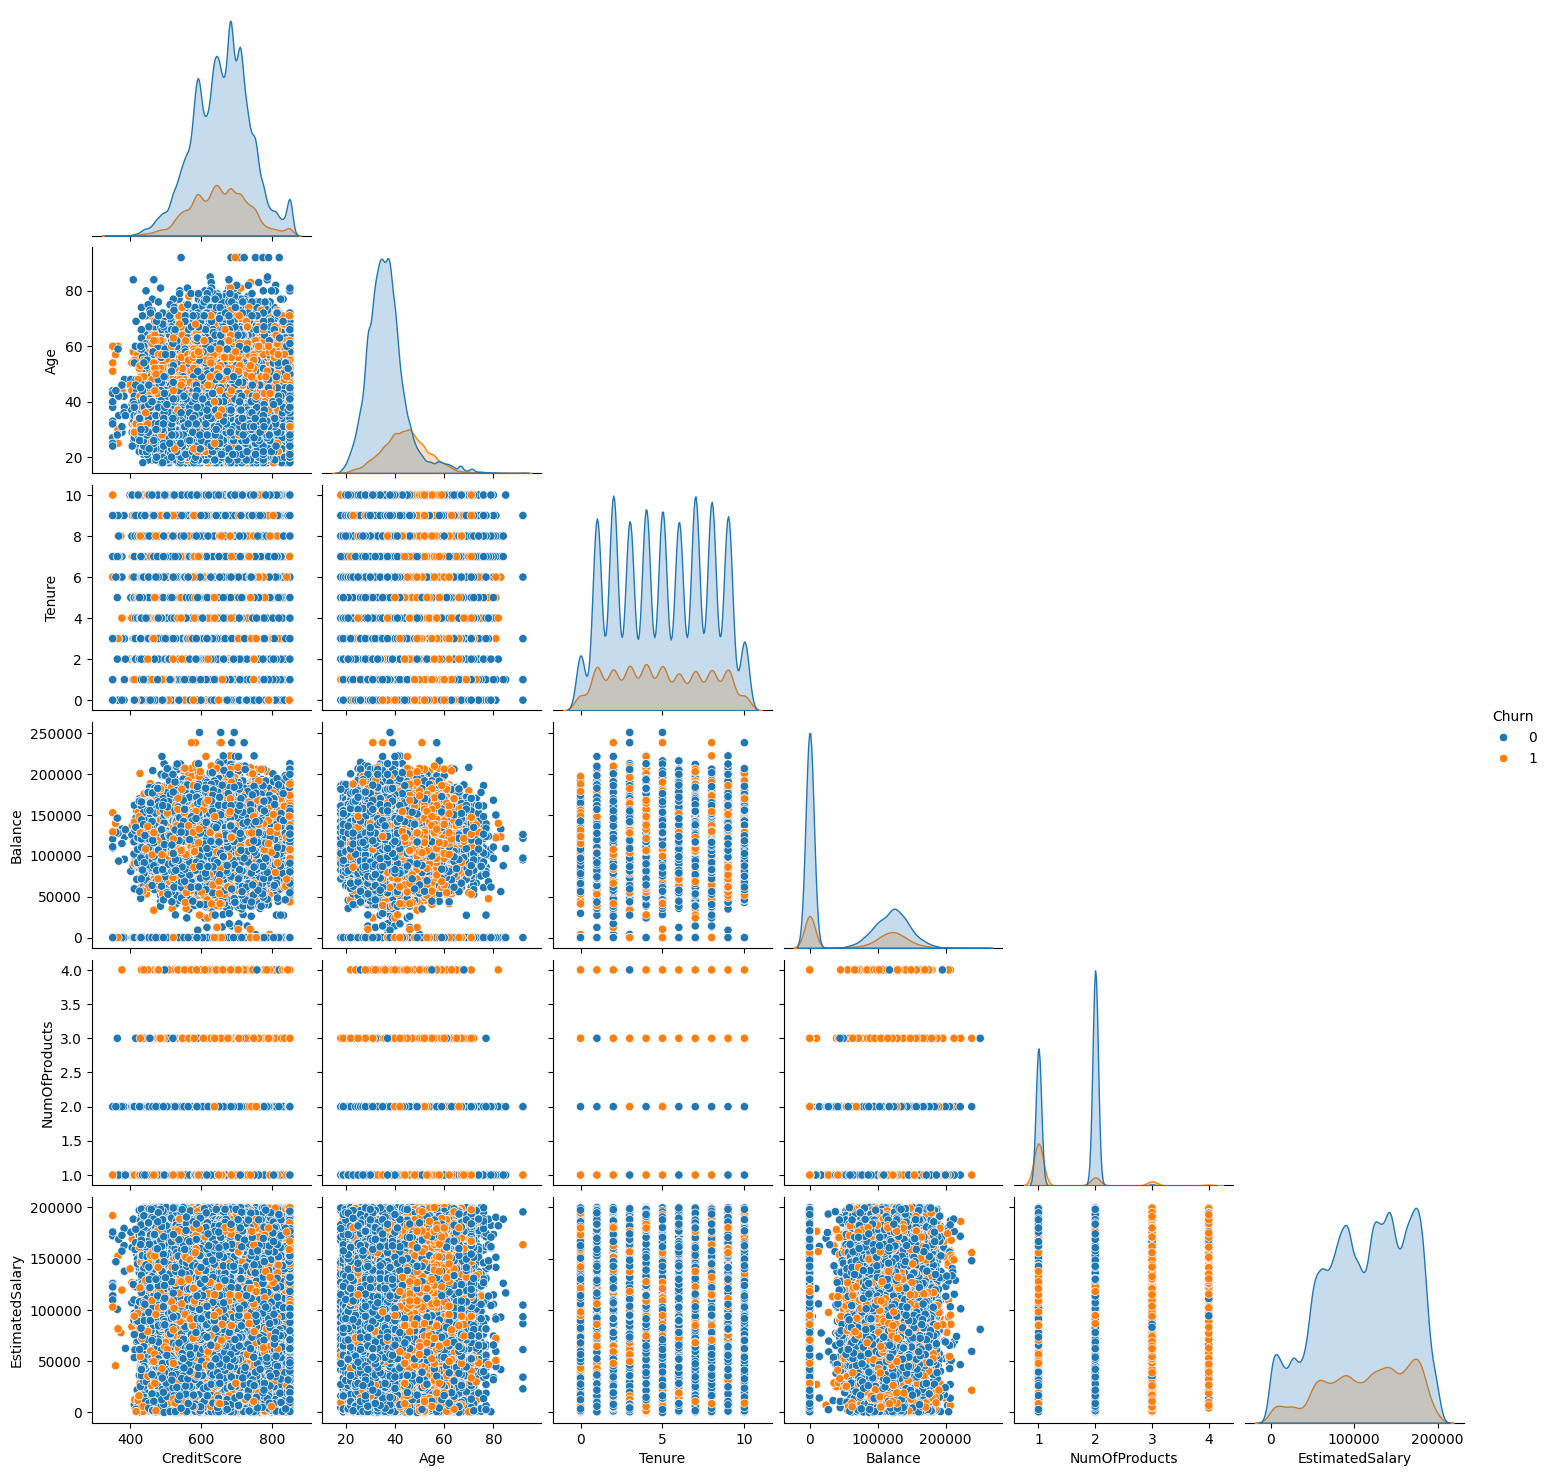

In [9]:
### Check relationships between variables and distributions

sb.pairplot(data[con_vars+["Churn"]], hue="Churn", corner=True)

In [10]:
# Age seems to be the most important feature (the peak of distribution for both churn and no churn doesnt match)
# i.e. there is a range of age which is more likely people "churn"

# Besides, NumOfProducts seems to be another important feature: between more products, more likely "churn"

In [11]:
### Get dummies for non binary categorical variables

drop_vars = ["id", "CustomerId", "Surname"]

data_ok = pd.get_dummies( data.drop(drop_vars, axis=1) )

data_ok

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,32.0,8,175406.13,1,1.0,0.0,172792.43,1,False,True,False,True,False
1,676,40.0,4,180520.41,2,1.0,1.0,171045.25,0,False,True,False,True,False
2,748,39.0,8,0.00,1,0.0,0.0,57323.18,1,True,False,False,True,False
3,641,39.0,4,0.00,1,1.0,0.0,45309.24,1,True,False,False,True,False
4,688,42.0,9,161588.89,2,0.0,1.0,54019.93,0,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148526,685,44.0,7,122570.69,1,0.0,1.0,84760.32,1,False,False,True,False,True
148527,650,49.0,7,116993.65,2,1.0,0.0,160589.85,0,True,False,False,True,False
148528,637,40.0,5,0.00,2,1.0,0.0,94488.82,1,False,False,True,False,True
148529,739,53.0,5,0.00,1,1.0,0.0,120801.65,1,True,False,False,True,False


In [14]:
### Prepare our data

X = data_ok.drop("Churn", axis=1)
y = data_ok["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


# Since feature values have very different ranges, we must scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
### Models to evaluate

models =  [(SVC(), {'svc__C': [0.01, 0.1, 1, 10, 100],
                    'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                    'svc__kernel': ["rbf", "linear"]} ),
           (LogisticRegression(), {'logisticregression__C': [0.01, 0.1, 1, 10, 100],
                                   'logisticregression__penalty': ["l1", "l2"]} ),
           (RandomForestClassifier(), {'randomforestclassifier__max_depth': [5,10,15,20],
                                       'randomforestclassifier__max_features': [1,4,8,12]}),
           (GradientBoostingClassifier(), {'gradientboostingclassifier__learning_rate': [0.01, 0.05, 0.1],
                                           'gradientboostingclassifier__max_depth': [5,10,15]} )]

In [21]:
### Lets use Gridsearch for tuning hyperparameters for each model

best_params = []
for clf, params in models:

    pipe = make_pipeline(MinMaxScaler(), clf)
    grid = GridSearchCV(pipe, param_grid=params, cv=4, scoring="recall", n_jobs=-1)

    grid.fit(X_train, y_train)

    # The third element of tuple represent how well model generalize
    best_params.append( (clf, grid.best_params_, grid.score(X_test, y_test)) )

# This process consumes large time, because cross-validation splits data into several folds, and implies many iterations

In [40]:
### Finally, select best model and predict customer churn with inference data

best_model = max(best_params, key=lambda x: x[-1])[0]   
params = max(best_params, key=lambda x: x[-1])[1] 

clean_name_params = {p.split("__")[-1]:val for p,val in params.items()}
best_model.set_params(**clean_name_params)

best_model.fit(X_train_scaled, y_train)


X_inference = pd.get_dummies( inference.drop(drop_vars, axis=1) )
X_inference_scaled = scaler.transform(X_inference)

preds = best_model.predict(X_inference_scaled)